In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from math import ceil
from typing import Union, List, Tuple, Dict
from operator import itemgetter
import random

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, Tensor
from torch.optim import Adam
from torchsummary import summary


### Prepare dataset

In [4]:
#load data from csv
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Innolab/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Innolab/train.csv")

In [5]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Innolab")
import data_loader as dtl

In [6]:
def preprocess_conn_matrix(df, train_data = True):
    #create target
    y, X = dtl.preprocess_data(df)
    y = np.array(y, dtype=np.float32)

    #drop columns
    cols_to_drop = ["MEM_score", "Apoe", "age", "sex", "edyears"]
    X.drop(columns=cols_to_drop, inplace = True)
    
    # if train_data:
    #     scaler.fit_transform(X)
    # else:
    #     scaler.transform(X)

    #turn array to matrix
    n_c = dtl.flat_to_mat(X.iloc[0,:]).shape[0]
    n_train = len(X)
    X_train_2d = np.zeros(n_train*n_c*n_c).reshape(n_train,n_c,n_c)

    for i in range(n_train):
      X_train_2d[i] = dtl.flat_to_mat(X.iloc[i,:])

    #reshape data
    X_train_2d = X_train_2d.reshape(X_train_2d.shape[0], 1, X_train_2d.shape[1], X_train_2d.shape[2])

    return X_train_2d, y

In [7]:
def data_augmentation_gaussian(X,y, scale = .17):
    X_noise = X.copy()
    y_noise = y.copy()

    for i in range(X.shape[0]):
        #add gaussian noise
        noise = np.random.normal(loc = 0, scale = scale, size = (X.shape[1], X.shape[2]))
        X_noise[i] = X[i] + np.triu(noise, k=1) + np.triu(noise, k=1).T

    return np.concatenate((X, X_noise), axis = 0), np.concatenate((y, y_noise), axis = 0)

In [8]:
X_train, y_train = preprocess_conn_matrix(train, train_data = True)
X_test, y_test = preprocess_conn_matrix(test, train_data = False)

In [9]:
X_train_aug,y_train_aug = data_augmentation_gaussian(X_train,y_train, scale = .17)

In [34]:
X_train_aug = torch.from_numpy(X_train_aug)
X_train_aug.shape

torch.Size([600, 1, 246, 246])

In [46]:
class ConnectomeTrainDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    # The `__len__` method should return the number of samples in the dataset.
    # This will later on be used automatically by the data loader.
    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx].float(), self.labels[idx]

In [42]:
class ConnectomeTestDataset(Dataset):
    def __init__(self):
        self.label = y_test
        self.feature = torch.from_numpy(X_test)
        self.n_samples = X_test.shape[0]

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.feature[idx].float(), self.label[idx]

In [48]:
shuffled_indices = list(range(len(X_train_aug)))
random.shuffle(shuffled_indices)

train_idxs = shuffled_indices[:500]
val_idxs = shuffled_indices[500:]

val_x = itemgetter(*val_idxs)(X_train_aug)
val_y = itemgetter(*val_idxs)(y_train_aug)

train_x = itemgetter(*train_idxs)(X_train_aug)
train_y = itemgetter(*train_idxs)(y_train_aug)

train_dataset = ConnectomeTrainDataset(train_x, train_y)
val_dataset = ConnectomeTrainDataset(val_x, val_y)
test_dataset = ConnectomeTestDataset()

In [51]:
train_dataset[0][0]

tensor([[[ 0.0000,  0.4474,  0.3971,  ...,  0.1804, -0.2177, -0.4664],
         [ 0.4474,  0.0000, -0.1504,  ...,  0.2086, -0.0661, -0.1469],
         [ 0.3971, -0.1504,  0.0000,  ...,  0.0933, -0.1357, -0.0318],
         ...,
         [ 0.1804,  0.2086,  0.0933,  ...,  0.0000, -0.0530, -0.0451],
         [-0.2177, -0.0661, -0.1357,  ..., -0.0530,  0.0000,  0.6008],
         [-0.4664, -0.1469, -0.0318,  ..., -0.0451,  0.6008,  0.0000]]])

In [52]:
torch.save(train_dataset, '/content/drive/MyDrive/Colab Notebooks/Innolab/train.pt')
torch.save(test_dataset, '/content/drive/MyDrive/Colab Notebooks/Innolab/test.pt')

### Train Model

In [88]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=64,
        kernel_size=(246, 1),
        stride = (1,1),
        padding = "valid"
    ),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Conv2d(64,
              128,
              (1, 246), 
              stride = (1,1),
              padding = "valid"),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Flatten(),
    nn.Linear(128,96),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(96,1),
    nn.Sigmoid()
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [89]:
model.to(device)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(246, 1), stride=(1, 1), padding=valid)
  (1): ReLU()
  (2): Dropout(p=0.6, inplace=False)
  (3): Conv2d(64, 128, kernel_size=(1, 246), stride=(1, 1), padding=valid)
  (4): ReLU()
  (5): Dropout(p=0.6, inplace=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=128, out_features=96, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.6, inplace=False)
  (10): Linear(in_features=96, out_features=1, bias=True)
  (11): Sigmoid()
)

In [90]:
summary(model, input_size=(1, 246, 246), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 1, 246]          15,808
              ReLU-2           [-1, 64, 1, 246]               0
           Dropout-3           [-1, 64, 1, 246]               0
            Conv2d-4            [-1, 128, 1, 1]       2,015,360
              ReLU-5            [-1, 128, 1, 1]               0
           Dropout-6            [-1, 128, 1, 1]               0
           Flatten-7                  [-1, 128]               0
            Linear-8                   [-1, 96]          12,384
              ReLU-9                   [-1, 96]               0
          Dropout-10                   [-1, 96]               0
           Linear-11                    [-1, 1]              97
          Sigmoid-12                    [-1, 1]               0
Total params: 2,043,649
Trainable params: 2,043,649
Non-trainable params: 0
---------------------------

##### Model Parameters

In [91]:
loss = (
    nn.BCELoss()
)

optimizer = (
    Adam(model.parameters(), weight_decay= 0.01)
)

def get_accuracy(prediction: Tensor, target: Tensor) -> float:
    return float(torch.sum(((prediction > 0.5) == target).float()) / len(prediction))

In [92]:
epochs = 50
batch_size = 8
num_workers = 4

max_batches = ceil(len(train_dataset) / batch_size)

In [93]:
def train(
    model: nn.Module,
    loss: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int,
    epochs: int,
    early_stopping: bool = False,
    patience: int = 2,
) -> Dict:

    # Define a dict with room for metrics that will be populated during training.
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Track how often in a row no improvements happen
    early_stopping_strikes = 0

    # The loader allows to shuffle the training data on the fly.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for ep in range(1, epochs + 1):

        batch_losses = []
        predictions = []
        targets = []

        for batch_idx, (x, y) in enumerate(train_loader):
            model.train()
            # Push tensors to device
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x).squeeze()
            batch_loss = loss(y_hat ,y)
            #set gradients to zero
            optimizer.zero_grad()
            #backpropagte the error
            batch_loss.backward()
            #apply gradients
            optimizer.step()

            ####################################################
            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)

        ep_train_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_train_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        batch_losses.clear()
        predictions.clear()
        targets.clear()


        for batch_idx, (x,y) in enumerate(val_loader):
            model.eval()

            # Push tensors to device
            x = x.to(device)
            y = y.to(device)

            with torch.no_grad():
                # Forward pass through the model
                y_hat = model(x).squeeze()
                # Obtain the loss
                batch_loss = loss(y_hat, y)
            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)

        ep_val_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_val_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))
        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)
        
        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.2f}'
              '\tVAL LOSS:\t {:.5f}\tVAL ACCURACY:\t {:.2f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_val_loss, ep_val_acc), end='\r')
        
        ###############################################################
        # EARLY STOPPING
        ###############################################################
        if early_stopping and ep > 1:
            if metrics['val_loss'][-2] <= metrics['val_loss'][-1]:
                early_stopping_strikes += 1
            else:
                early_stopping_strikes = 0

            if early_stopping_strikes >= patience:
                break

    return metrics

metrics = train(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    early_stopping=True,
    patience=5
)

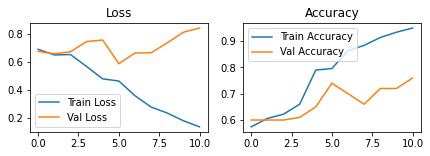

In [94]:
def get_training_progress_plot(
        train_losses: List[float],
        train_accs: List[float],
        val_losses: List[float],
        val_accs: List[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.legend()

get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['val_loss'],
    metrics['val_acc'],
)

In [96]:

def evaluate(model: nn.Module, test_dataset: Dataset, batch_size: int = 512) -> Dict:
    batch_losses: List = []
    predictions: List = []
    targets: List = []

    for x, y in DataLoader(test_dataset, batch_size):
        model.eval()

        # Push tensors to device
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = model(x).squeeze()
            batch_loss = loss(y_hat, y)

        ############################################

        batch_losses.append(batch_loss)
        predictions.append(y_hat.detach())
        targets.append(y)

    eval_loss = float(torch.mean(torch.stack(batch_losses)))
    eval_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

    return {'test_loss': eval_loss, 'test_acc': eval_acc}

eval_metrics = evaluate(model, test_dataset)
print(eval_metrics)

{'test_loss': 1.1178381443023682, 'test_acc': 0.602739691734314}


In [ ]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1024,
    num_workers=4,
)

total_loss = 0
num_correct = 0

for batch_idx, (x, y) in enumerate(train_loader):
    # Push tensors to device
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      y_hat = model(x).squeeze()
      batch_loss = loss(y_hat,y)

    total_loss += float(batch_loss)
    num_correct += int(torch.sum(torch.round(y_hat) == y))

print('EVALUATION LOSS:\t{:.3f}\tEVALUATION: ACCURACY:\t{:.3f}'
          .format(total_loss / len(train_dataset), num_correct / len(train_dataset),
                  end='\r'))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


EVALUATION LOSS:	0.069	EVALUATION: ACCURACY:	0.769
